<a href="https://colab.research.google.com/github/amyfthau/CFGSum23D1G4/blob/data_modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
# Import relevant libraries to mount drive
from google.colab import drive
import os
# Mount google drive
drive.mount('/content/drive')

# Define the path to your specific folder
specific_folder_path = '/content/drive/MyDrive/CFGdegree_Sum23_D1_G4'

# Navigate to the specific folder
os.chdir(specific_folder_path)

# Change directory to shared group folder
%cd /content/drive/MyDrive/CFGdegree_Sum23_D1_G4




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [141]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import requests  # For making HTTP requests
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
# from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller  # For performing Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from matplotlib.pylab import rcParams  # For setting plot parameters
from datetime import datetime  # For working with date and time data
from statsmodels.tsa.exponential_smoothing.ets import ETSModel  # For Exponential Smoothing (ETS) model
from statsmodels.tsa.arima_model import ARIMA  # For Autoregressive Integrated Moving Average (ARIMA) model
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm  # For advanced statistical models and tests
from statsmodels.graphics.tsaplots import plot_acf  # For autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf  # For partial autocorrelation plot
from sklearn import preprocessing  # For data preprocessing tasks
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets


Import relevant data

In [142]:
# Specify the file path for the UK House Price Index (UKHPI) data
UKHPI2022path = '/content/drive/MyDrive/CFGdegree_Sum23_D1_G4/Data_Collection/Predicting_House_Prices/UK-HPI-full-file-2022-01.csv'

# Read the UKHPI data into a DataFrame
UKHPI2022_df = pd.read_csv(UKHPI2022path)

# Display the contents of the DataFrame
print(UKHPI2022_df.head())

         Date     RegionName   AreaCode  AveragePrice      Index  IndexSA  \
0  01/01/2004  Aberdeenshire  S12000034   81693.66964  40.864214      NaN   
1  01/02/2004  Aberdeenshire  S12000034   81678.76231  40.856757      NaN   
2  01/03/2004  Aberdeenshire  S12000034   83525.09702  41.780317      NaN   
3  01/04/2004  Aberdeenshire  S12000034   84333.67900  42.184780      NaN   
4  01/05/2004  Aberdeenshire  S12000034   86379.95396  43.208353      NaN   

   1m%Change  12m%Change  AveragePriceSA  SalesVolume  ...     NewPrice  \
0        NaN         NaN             NaN        388.0  ...  88436.13953   
1  -0.018248         NaN             NaN        326.0  ...  88606.44649   
2   2.260483         NaN             NaN        453.0  ...  90296.91375   
3   0.968071         NaN             NaN        571.0  ...  90319.87844   
4   2.426403         NaN             NaN        502.0  ...  91989.17763   

    NewIndex  New1m%Change  New12m%Change  NewSalesVolume     OldPrice  \
0  40.267250

Functions

In [143]:
# Function to filter data for a specific region
def filter_region_data(data_frame, region_name):
    """
    Filter the data for a specific region.

    Args:
        data_frame (pandas.DataFrame): The DataFrame containing the UKHPI data.
        region_name (str): The name of the region to filter.

    Returns:
        pandas.DataFrame: The filtered data for the specified region.
    """
    return data_frame[data_frame['RegionName'] == region_name]

# Function to plot a specified column for a region
def plot_column_into_line_graph(data_frame, region_name, column_name):
    """
    Plot a specified column for a region.

    Args:
        data_frame (pandas.DataFrame): The DataFrame containing the UKHPI data.
        region_name (str): The name of the region to plot.
        column_name (str): The name of the column to plot.

    Returns:
        None
    """
    region_data = filter_region_data(data_frame, region_name)

    region_data.plot(x='Date', y=column_name, marker='o', markersize = '2', linewidth='2')

    plt.xlabel("Date", fontsize=15)
    # Rotate the tick labels vertically
    plt.xticks(rotation=45)
    plt.ylabel(column_name, fontsize=15)
    plt.title(f"{column_name} per Month for {region_name}", fontsize=16)

    plt.show()

Plot average prices for "Ashford" first

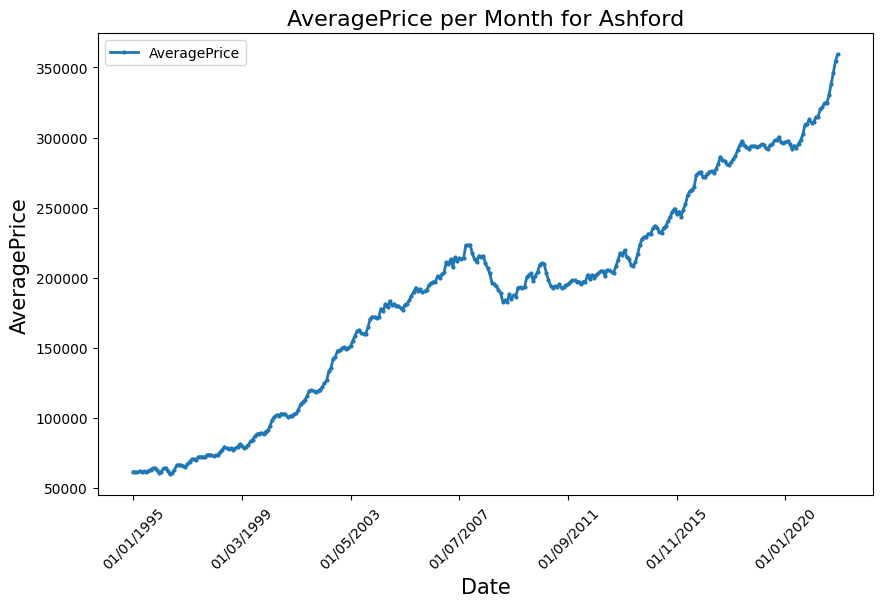

In [144]:
# Specify the column name to plot
column_to_plot = 'AveragePrice'
# Call the function to plot the specified column data for the 'Ashford' region
plot_column_into_line_graph(UKHPI2022_df, 'Ashford', column_to_plot)


Plot change in house prices - month change

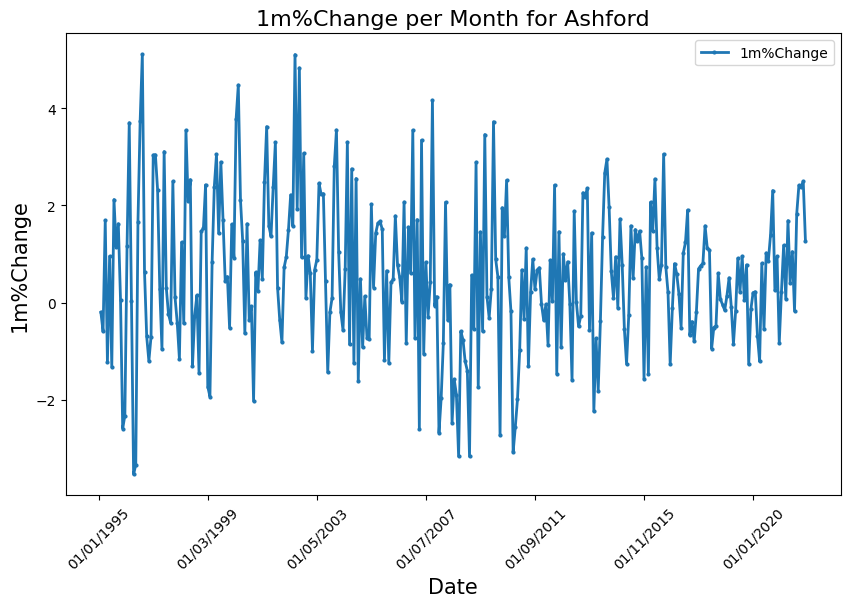

In [145]:
# Specify the column name to plot
column_to_plot = '1m%Change'
# Call the function to plot the specified column data for the 'Ashford' region
plot_column_into_line_graph(UKHPI2022_df, 'Ashford', column_to_plot)

In [149]:
# Create series

# Set the start and end dates for the index
start_date = "1995-01-01"
end_date = "2022-01-01"

# Create a date range for the index
index = pd.date_range(start_date, end_date, freq="M")

# Create a Series with the forecasting variable and the custom index
monthly_p_change_Ashford = pd.Series(UKHPI2022_df[UKHPI2022_df['RegionName'] == 'Ashford']['1m%Change'].dropna().values, index=index)
"""
 This series represents the monthly percentage change in the housing price index for the region of Ashford.
 Each entry in this series represents the percentage change in the housing price index compared to the previous month. The values fluctuate over time,
 indicating that the rate of change in housing prices is not constant and varies from month to month.
 The overall pattern suggests that there have been periods of both positive and negative changes in housing prices in the Ashford region.
"""



# Create a Series with actual values - needed to convert rates of change back to levels
monthly_avg_p_Ashford = pd.Series(UKHPI2022_df[UKHPI2022_df['RegionName'] == 'Ashford']['AveragePrice'].dropna().values).iloc[1:]
monthly_avg_p_Ashford.index = index
"""
This series represents the actual average housing prices for the region of Ashford.
Each entry in this series represents the average housing price for a specific month. The values generally show an increasing trend over time,
 which suggests that the housing prices in the Ashford region have been increasing on average. The overall pattern indicates long-term appreciation
 in housing prices, with fluctuations and variations over the years.
"""


print(monthly_p_change_Ashford, monthly_avg_p_Ashford)


1995-01-31   -0.200227
1995-02-28   -0.596663
1995-03-31    1.689811
1995-04-30   -1.232108
1995-05-31    0.951496
                ...   
2021-08-31    1.819840
2021-09-30    2.411058
2021-10-31    2.378589
2021-11-30    2.494619
2021-12-31    1.275467
Freq: M, Length: 324, dtype: float64 1995-01-31     61216.13694
1995-02-28     60850.88266
1995-03-31     61879.14767
1995-04-30     61116.72955
1995-05-31     61698.25293
                  ...     
2021-08-31    330220.45570
2021-09-30    338182.26280
2021-10-31    346226.23040
2021-11-30    354863.25420
2021-12-31    359389.41810
Freq: M, Length: 324, dtype: float64


The data is already detrended because we're looking at growth rates so the data is stationary.

In [147]:
# Conduct Dickey-Fuller Test
#Ho: It is non stationary
#H1: It is stationary


def adfuller_test(data):
    """
    Conducts the Dickey-Fuller test to check for stationarity of a time series.

    Args:
        data (pandas.Series): The time series data to be tested.

    Returns:
        None
    """
    result = adfuller(data)
    labels = ['ADF Test Statistic', 'p-value', 'Lags Used in The Test', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))

    if result[1] <= 0.05:
        print("P value is less than 0.05, so we can reject the null hypothesis (Ho). The series is stationary.")
    else:
        print("Weak evidence against null hypothesis. The series has a unit root and is not stationary.")


# Call the adfuller_test function for the 'Ashford' region's 1-month percentage change data
print("Dickey-Fuller Test for Ashford Region:")
adfuller_test(monthly_p_change_Ashford)

# Function to plot ACF and PACF
def plot_acf_pacf(data_series, max_lags=24):
    """
    Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

    Args:
        data_series (pandas.Series): The time series data.
        max_lags (int): Maximum number of lags to show in the plots.

    Returns:
        None
    """
    rcParams['figure.figsize'] = (10, 6)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

    # Plot Autocorrelation Function (ACF)
    plot_acf(data_series, lags=max_lags, ax=ax1)
    ax1.set_xlim(0, max_lags)
    ax1.set_xlabel("Lags", fontsize=12)
    ax1.set_ylabel("ACF", fontsize=12)
    ax1.set_title("Autocorrelation Function (ACF)", fontsize=14)

    # Plot Partial Autocorrelation Function (PACF)
    plot_pacf(data_series, lags=max_lags, ax=ax2)
    ax2.set_xlim(0, max_lags)
    ax2.set_ylim(-1, 1)
    ax2.set_xlabel("Lags", fontsize=12)
    ax2.set_ylabel("PACF", fontsize=12)
    ax2.set_title("Partial Autocorrelation Function (PACF)", fontsize=14)

    plt.tight_layout()
    plt.show()


Dickey-Fuller Test for Ashford Region:
ADF Test Statistic: -3.5023740673376884
p-value: 0.007926331906269837
Lags Used in The Test: 17
Number of Observations Used: 306
P value is less than 0.05, so we can reject the null hypothesis (Ho). The series is stationary.


In [134]:
# # if time series is not stationary-

# def differencing_series(df):
#   axes = plt.subplots(3, 2)
# # Original Series
#   axes[0, 0].plot(df.value)
#   axes[0, 0].set_title('Original Series')
#   plot_acf(df.value, ax=axes[0, 1])

# # 1st Differencing
#   axes[1, 0].plot(df.value.diff())
#   axes[1, 0].set_title('1st Order Diff')
#   plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# # 2nd Differencing
#   axes[2, 0].plot(df.value.diff().diff())
#   axes[2, 0].set_title('2nd Order Diff')
#   plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

#   plt.show()

# # pick a plot which shows stationarity (there is basically no clear pattern shown in the plot)

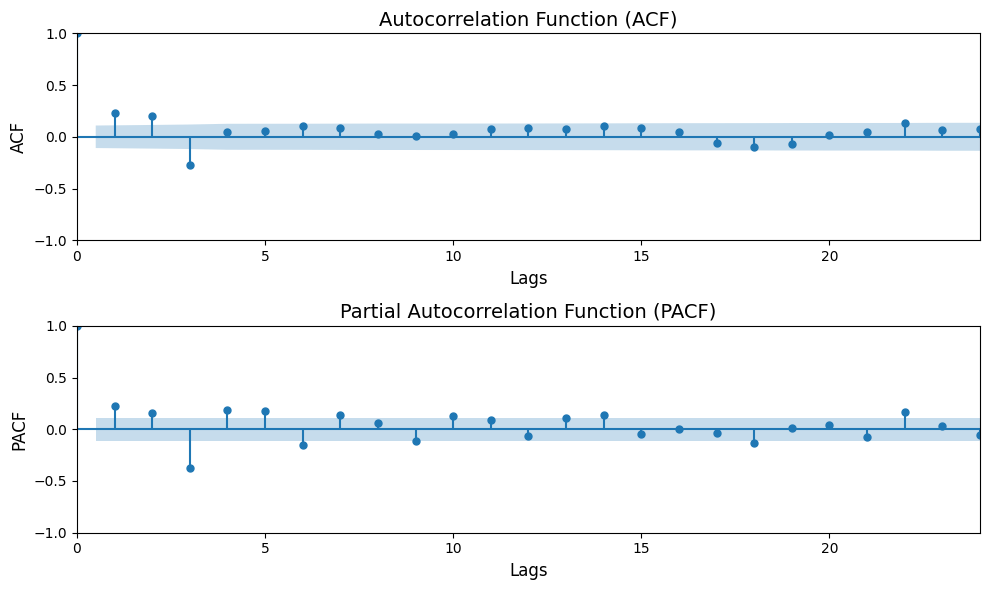

DatetimeIndex(['1995-01-31', '1995-02-28', '1995-03-31', '1995-04-30',
               '1995-05-31', '1995-06-30', '1995-07-31', '1995-08-31',
               '1995-09-30', '1995-10-31',
               ...
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', length=324, freq='M')


In [135]:
# Plot ACF and PACF
plot_acf_pacf(monthly_p_change_Ashford)
print(index)

Autoregressive (AR) Component (p):
Look at the PACF plot. The lag at which the PACF cuts off or becomes close to zero can suggest the value of p. If the PACF cuts off after lag k, then you might consider an AR(p) term in your model.
Moving Average (MA) Component (q):
Look at the ACF plot. The lag at which the ACF cuts off or becomes close to zero can suggest the value of q. If the ACF cuts off after lag k, then you might consider an MA(q) term in your model.


1. The positive autocorrelation at the first and second lags (lags 1 and 2) around 0.25 suggests that there is a moderate positive correlation between the current observation and observations at these lags. This might indicate a recurring pattern every 1 or 2 periods.
The negative autocorrelation at the third lag (lag 3) around -0.25 indicates that there is a moderate negative correlation between the current observation and the observation three periods ago. This could suggest an alternating pattern The positive partial autocorrelation at the first lag suggests a strong direct relationship between the current observation and the observation at the first lag. This is typical of an autoregressive (AR) component in a time series model.The positive partial autocorrelation at the second lag indicates that there is still some correlation between the current observation and the observation two periods ago, even after accounting for the first lag. This could also be indicative of an AR component. The negative partial autocorrelation at the third lag suggests that there is a negative relationship between the current observation and the observation three periods ago, once the influence of the first two lags has been removed. This pattern may suggest a seasonal or moving average (MA) component.



2. Peaks and troughs of the ACF curve that alternate in a regular pattern suggest the presence of seasonality.
It's important to consider seasonality when modeling time series data, as it can impact the choice of forecasting models and the interpretation of results. Seasonal patterns may need to be addressed through techniques such as seasonal decomposition, differencing, or incorporating seasonal terms in forecasting models like Seasonal Autoregressive Integrated Moving Average (SARIMA) or Seasonal Exponential Smoothing (ETS).


In [136]:
print(monthly_p_change_Ashford.index)
print(monthly_p_change_Ashford.dtypes)


DatetimeIndex(['1995-01-31', '1995-02-28', '1995-03-31', '1995-04-30',
               '1995-05-31', '1995-06-30', '1995-07-31', '1995-08-31',
               '1995-09-30', '1995-10-31',
               ...
               '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', length=324, freq='M')
float64


y               mean   mean_se  mean_ci_lower  mean_ci_upper
2022-01-31  0.887574  1.186755      -1.438423       3.213570
2022-02-28 -0.502277  1.278884      -3.008844       2.004290
2022-03-31  0.674460  1.395576      -2.060820       3.409739
2022-04-30  0.745192  1.518991      -2.231975       3.722359
2022-05-31  0.893049  1.524784      -2.095474       3.881571
...              ...       ...            ...            ...
2052-08-31  0.037877  1.654440      -3.204766       3.280520
2052-09-30  0.038129  1.654444      -3.204522       3.280780
2052-10-31  0.037418  1.654449      -3.205242       3.280078
2052-11-30  0.035860  1.654454      -3.206810       3.278530
2052-12-31  0.033749  1.654459      -3.208932       3.276430

[372 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
             lower y   upper y
2022-01-31 -1.438423  3.213570
2022-02-28 -3.008844  2.004290
2022-03-31 -2.060820  3.409739
2022-04-30 -2.231975  3.722359
2022-05-31 -2.095474  3.881571
...              ...

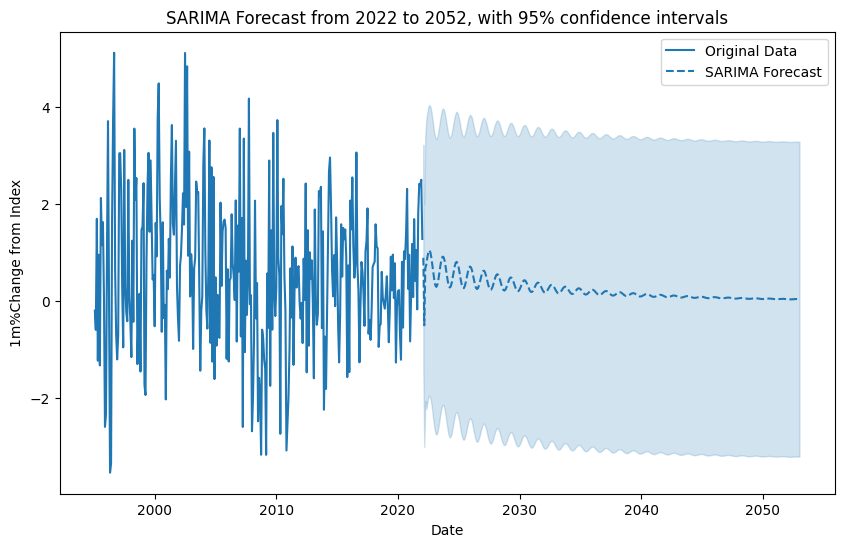

In [152]:
# SARIMA Model
p = 3 # Autoregressive component
d = 0 # Differencing (our data is already stationary)
q = 7 # Moving average component
P, D, Q, s = 0, 0, 0, 6 # P: Seasonal autoregressive order, D: Seasonal difference order, Q: Seasonal moving average order, m: The number of time steps for a single seasonal period.

# from which I could find I need to count the significant spikes from the first(0th), significant meaning they are outside the blue boundary
# creating a function is based on where the significant spikes are so will have to write this into the function. (find how to do this?)
# SARIMA Model

# Create and fit the SARIMA model
SARIMA_model = SARIMAX(monthly_p_change_Ashford, order=(p, d, q), seasonal_order=(P, D, Q, s))
# fit model (ARIMA(3,0,1) - ARIMA(p,d,q) - the data has already stationary so the d value is 0
SARIMA_fit = SARIMA_model.fit(maxiter=1000)  # Increase the number of iterations


# Forecast from 2022 to 2052
forecast_steps = 12 * (2052 - 2022 + 1)  # Number of steps to forecast
SARIMA_forecast = SARIMA_fit.get_forecast(steps=forecast_steps)
confidence_intervals = SARIMA_forecast.summary_frame(alpha=0.05)
print(confidence_intervals)
print(type(confidence_intervals))

# Plot the SARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_p_change_Ashford.index, monthly_p_change_Ashford.values, label='Original Data')
plt.plot(SARIMA_forecast.predicted_mean.index, SARIMA_forecast.predicted_mean.values, color='#1f77b4', linestyle='--', label='SARIMA Forecast')
print(SARIMA_forecast.conf_int())
# Plot confidence intervals
plt.fill_between(SARIMA_forecast.predicted_mean.index,
                 confidence_intervals['mean_ci_lower'],
                 confidence_intervals['mean_ci_upper'],
                 color='#1f77b4', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('1m%Change from Index')
plt.title('SARIMA Forecast from 2022 to 2052, with 95% confidence intervals')
plt.legend()
plt.show()



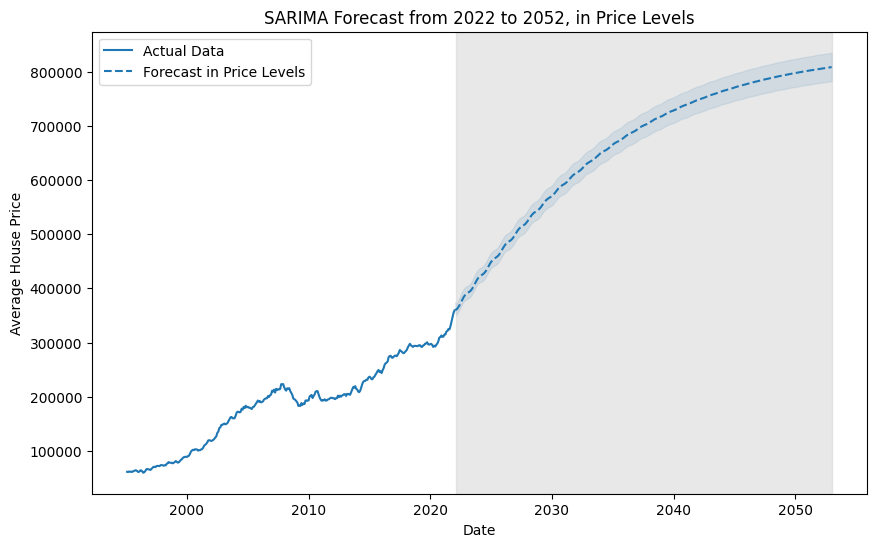

In [163]:
# Revert the monthly percentage change forecast back into levels (average house prices)
initial_price = monthly_avg_p_Ashford.iloc[-1]
forecasted_change = SARIMA_forecast.predicted_mean.values[0]
forecasted_price_levels = [initial_price * (1 + forecasted_change / 100)]

# Calculate the forecasted values and confidence intervals for the rest of the period
for change, lower_ci, upper_ci in zip(SARIMA_forecast.predicted_mean.values[1:], confidence_intervals['mean_ci_lower'].values[1:], confidence_intervals['mean_ci_upper'].values[1:]):
    forecasted_price = forecasted_price_levels[-1] * (1 + change / 100)
    lower_price = forecasted_price * (1 + lower_ci / 100)
    upper_price = forecasted_price * (1 + upper_ci / 100)
    forecasted_price_levels.append(forecasted_price)

# Create a new Series with the forecasted price levels
forecasted_price_series = pd.Series(forecasted_price_levels, index=SARIMA_forecast.predicted_mean.index)

# Plot the SARIMA forecast in price levels
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_p_Ashford.index, monthly_avg_p_Ashford.values, label='Actual Data')
plt.plot(forecasted_price_series.index, forecasted_price_series.values, color='#1f77b4', linestyle='--', label='Forecast in Price Levels')

# Plot confidence intervals
plt.fill_between(forecasted_price_series.index,
                 forecasted_price_series * (1 + confidence_intervals['mean_ci_lower'] / 100),
                 forecasted_price_series * (1 + confidence_intervals['mean_ci_upper'] / 100),
                 color='#1f77b4', alpha=0.2)

# Plot the forecasted region with a light grey background
forecast_start = pd.Timestamp('2022-01-31')
forecast_end = forecasted_price_series.index[-1]
plt.axvspan(forecast_start, forecast_end, color='lightgrey', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Average House Price')
plt.title('SARIMA Forecast from 2022 to 2052, in Price Levels')
plt.legend()
plt.show()


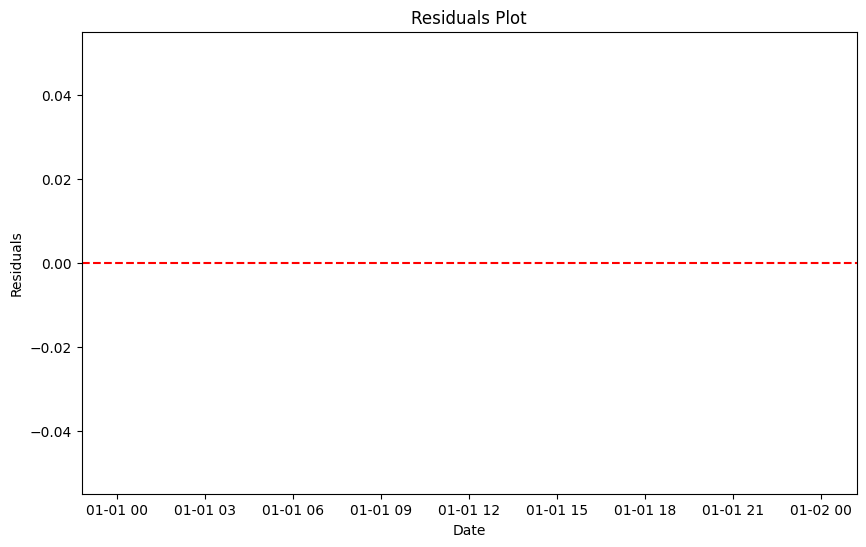

In [ ]:
#Training Data
# create training and tests sets
#training_data, testing_data = train_test_split(df_series, test_size = 0.2, random_state=42)
training_data = monthly_p_change_Ashford.sample(frac=0.8,random_state=42)
testing_data = monthly_p_change_Ashford.drop(training_data.index)
# set indexes for training and tests sets
index_train = pd.date_range("01/01/1995", "01/01/2010", freq="M")
index_test = pd.date_range("01/01/2011", "01/01/2022", freq="M")
# create series for forecasting variable
training_data=pd.Series(training_data, index=index_train)
testing_data=pd.Series(testing_data, index=index_test)

print('Number of training samples: {}, Number of testing samples: {}'.format(training_data.shape[0],testing_data.shape[0]))
print(training_data.shape)
print(index_train.shape)

# not sure whether these sould be NaN values but they are
#error below comes from here - why is there a NaN value?

Number of training samples: 180, Number of testing samples: 132
(180,)
(180,)


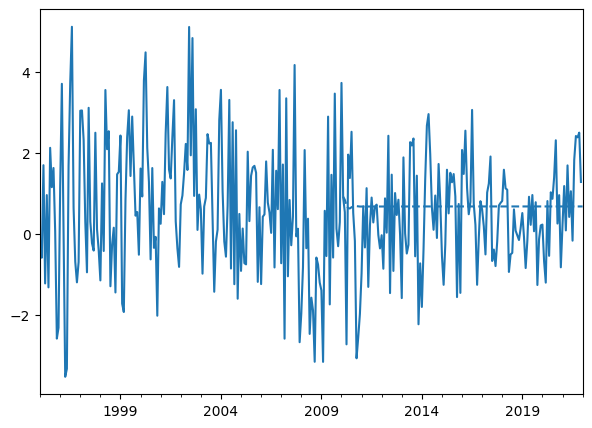

In [ ]:
# Training ARIMA model
#I chose a 80:20 (training:testing) split for training the data
def ARIMA_training_data(df_series,training_data):
  #Tried to do it a different way to you but it didnt work...
  #training_data, testing_data = train_test_split(df_series, test_size = 0.2, random_state=42)

  ARIMA_model_train = ARIMA(training_data,order=(3,0,1))
  ARIMA_fit_train = ARIMA_model_train.fit()
  ARIMA_forecast_train = ARIMA_fit_train.predict(start="2010", end="2022")[1:]
  ARIMA_forecast_train.plot(label="mean prediction", color='#1f77b4',linestyle="--")
  df_series.plot(label='Data')

ARIMA_training_data(monthly_p_change_Ashford,training_data)



In [ ]:
#Measuring performance of ARIMA

                mean  pi_lower  pi_upper
2022-01-31  0.808605 -2.191659  3.808869
2022-02-28  0.774294 -2.228758  3.777346
2022-03-31  0.541272 -2.464566  3.547109
2022-04-30  0.805815 -2.202806  3.814437
2022-05-31  0.808718 -2.202698  3.820134
2022-06-30  0.774401 -2.239794  3.788596
2022-07-31  0.541374 -2.475599  3.558346
2022-08-31  0.805912 -2.213835  3.825660
2022-09-30  0.808810 -2.213723  3.831343
2022-10-31  0.774488 -2.250815  3.799792
2022-11-30  0.541457 -2.486616  3.569529
2022-12-31  0.805991 -2.224848  3.836830
2023-01-31  0.808885 -2.224731  3.842500
2023-02-28  0.774560 -2.261818  3.810937
2023-03-31  0.541524 -2.497613  3.580661
2023-04-30  0.806055 -2.235839  3.847950
2023-05-31  0.808946 -2.235716  3.853607
2023-06-30  0.774617 -2.272797  3.822032
2023-07-31  0.541579 -2.508586  3.591744
2023-08-31  0.806107 -2.246806  3.859021
2023-09-30  0.808995 -2.246677  3.864667
2023-10-31  0.774664 -2.283751  3.833080
2023-11-30  0.541624 -2.519533  3.602781
2023-12-31  0.80

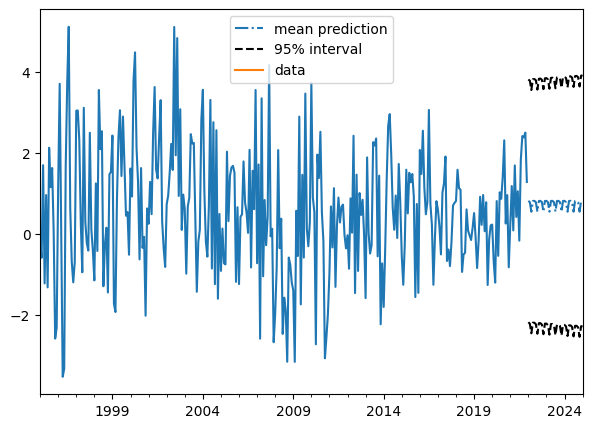

In [ ]:
#ETS model
#(make this into a function with input as monthly change series)
#run ETS AAA model, with damped trend and seasonal periods of 4
model_ETSforecast = ETSModel(
monthly_p_change_Ashford,
error="add",
trend="add",
seasonal="add",
damped_trend=True,
seasonal_periods=4,
)
# save model object
ETS_fit = model_ETSforecast.fit()
# run predictions
ETS_pred = ETS_fit.get_prediction(start="2022", end="2025")
# retreive predictions and confidence intervals with 95% confidence intervals (alpha=0.5)
df3 = ETS_pred.summary_frame(alpha=0.05)
print(df3)
# manually run simulations to produce confidence intervals
df3["mean"].plot(label="mean prediction", color='#1f77b4',linestyle="-.")
df3["pi_lower"].plot(linestyle="--", color="black", label="95% interval")
df3["pi_upper"].plot(linestyle="--", color="black", label="_")
monthly_p_change_Ashford.plot()
# label actual data and plot The endogenous/response variable
ETS_pred.endog.plot(label="data")
rcParams['figure.figsize']=7,5
# include legend
plt.legend()

In [ ]:
#ETS AAA Model Evaluation
model_ETSforecast_train = ETSModel(
training_data,error="add",
trend="add",
seasonal="add",
damped_trend=True,
seasonal_periods=4,).fit()

# run prediction
ETS_pred_train = model_ETSforecast_train.get_prediction(start="2010", end="2021")
# retreive predictions and confidence intervals with 95% confidence intervals (alpha=0.5)
df4 = ETS_pred_train.summary_frame(alpha=0.05)
df4['actual'] = testing_data.tolist()
df4["actual"].plot(linewidth = '3')
df4["mean"].plot(label="mean prediction", color='#1f77b4',linestyle="-.")
df4["pi_lower"].plot(linestyle="--", color="black", label="95% interval")
df4["pi_upper"].plot(linestyle="--", color="black", label="_")
plt.legend()


ValueError: ignored

In [ ]:
df3.shape

(37, 3)

ValueError: ignored

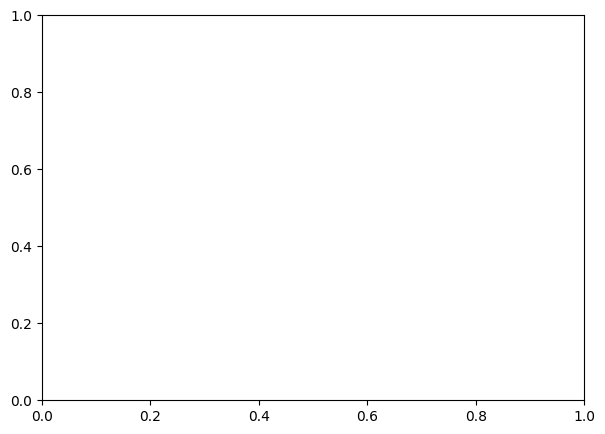

In [ ]:
# real predictive model
# should I be going back to the dataset and doing this with the actual prices instad of the %change? probably...
def plot_predictions(predictions,df,last_forecast_year):
  last_value = df.iat[-1]
  Dependent = df.values
  Y_pred_values = [] # Create list
  for predicted_growth in predictions:
    last_value = last_value*(1+predicted_growth/100)
    Y_pred_values.append(last_value)
  # Set the total data range and forecast range
  data_range = np.arange(1995,2022,1)
  forecast_range = np.arange(2023,last_forecast_year,1)
  total_range = np.concatenate([data_range,forecast_range])
  total_dependent = np.concatenate([Dependent,Y_pred_values])
  # Define plot space
  plt.plot(total_range, total_dependent)
  #plt.plot(total_range, A, color = "grey",linestyle="--" )
  # create A variable? (linear regression??)
  plt.xlabel("Year", fontsize=15)
  plt.ylabel("1%change Ashford", fontsize=15)
  plt.legend(['actual/forecast',"target"])
  # Set the Y axis to better reflect the
  plt.ylim([-4,6])
  # displaying the title
  plt.title("Housing price change in Ashford", fontsize=15)
  b1 = 2022
  b2 = 2052
  plt.axvspan(b1, b2, color='tab:olive', alpha=0.7)
  plt.show()






plot_predictions(df3["mean"],monthly_p_change_Ashford, 2052)

In [ ]:
# extending ARIMA to SARIMA (Seasonal - taking into account different parameters)

In [ ]:
# code as a function for whole dataset, and if we want to find a specific placename

Further work - label encoding for other variables to add into our predictive analysis